# Transcriptomic analysis

This is an example notebook performing standard transcriptomic analysis in TCGA-BRCA dataset. 

* (1) Load TCGA-BRCA data (either through API or local file)
* (2) The data is processed (normalised, scaled and outliers are removed)
* (3) QC using PCA to ensure no batch effects
* (4) Perform association analysis
* (5) Perform multvariate analysis (with unsupervised and supervised methods) 




#### Load libraries

In [1]:
# Import libraries
from pca import pca
from sklearn.preprocessing import StandardScaler

import gseapy
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as  pd
import scanpy as sc
import seaborn as sns

#Import custom functions
import utils

#### (1) Load data

In [2]:
#Load metadata
sample_metadata = pd.read_csv('biospecimen.cart.2023-07-11/sample.tsv', sep = '\t')
clinical_metadata = pd.read_csv('clinical.cart.2023-07-11/clinical.tsv', sep = '\t')

sample_metadata = sample_metadata[sample_metadata.project_id == 'TCGA-BRCA']#.merge(clinical_metadata, how = 'left', on = ['case_id', 'case_submitter_id'])
sample_metadata = sample_metadata.loc[:, (sample_metadata != sample_metadata.iloc[0]).any()] #erase constant cols (n= 147)
sample_metadata.set_index('sample_submitter_id', inplace = True)

sample_metadata.head()

,case_id,case_submitter_id,sample_id,composition,days_to_collection,days_to_sample_procurement,initial_weight,is_ffpe,oct_embedded,pathology_report_uuid,preservation_method,sample_type,sample_type_id,tumor_descriptor
sample_submitter_id,,,,,,,,,,,,,,
TCGA-E2-A154-01A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,093150bc-9ea8-4729-8693-32fe1d9690d2,Not Reported,461,'--,400.0,False,false,8F8DCA87-B27A-429C-952A-186F8D4502AE,'--,Primary Tumor,01,Not Reported
TCGA-E2-A154-10A,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,4576b0e9-023b-4735-8c17-8a3a22cf9c10,Not Reported,461,'--,'--,False,false,'--,'--,Blood Derived Normal,10,Not Reported
TCGA-E2-A154-01Z,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,f2792f6c-5eb3-4023-84be-06573ce00062,'--,'--,0,'--,True,No,'--,FFPE,Primary Tumor,01,'--
TCGA-LL-A5YM-10A,e9a12df9-024e-4cbc-b6bf-e4e87485fa90,TCGA-LL-A5YM,c81fa4f8-d7db-497e-925b-818b165a9f7a,Not Reported,131,'--,'--,False,false,'--,'--,Blood Derived Normal,10,Not Reported
TCGA-LL-A5YM-01A,e9a12df9-024e-4cbc-b6bf-e4e87485fa90,TCGA-LL-A5YM,cf5fda71-8fba-43fc-91f3-e4baa36571dd,Not Reported,131,'--,280.0,False,false,B169A5B5-27CD-48A6-A8D7-C14D3824A20A,'--,Primary Tumor,01,Not Reported


In [25]:
importlib.reload(utils)

<module 'utils' from '/Users/joannazamarbide/GitHubrepo/cancer_analyses_python/utils.py'>

In [26]:
# Load TCGA-BRCA transcriptomics
tcga_df = utils.load_transcriptomics(source = 'gdc', #Options are 'gdc' (if available in workspace) or 'api' (through TCGA API)
                                     sample_metadata = sample_metadata)

tcga_df.head()


### (2) Data processing
* To process the data, lowly expressed genes (< 10 TPM) are first removed. 
* Normalise the data with log transformation, which aids with measuring changes of gex between samples.
* Following, outliers are detected and removed using Hoetellings T2 and SPE methods.

<Axes: >

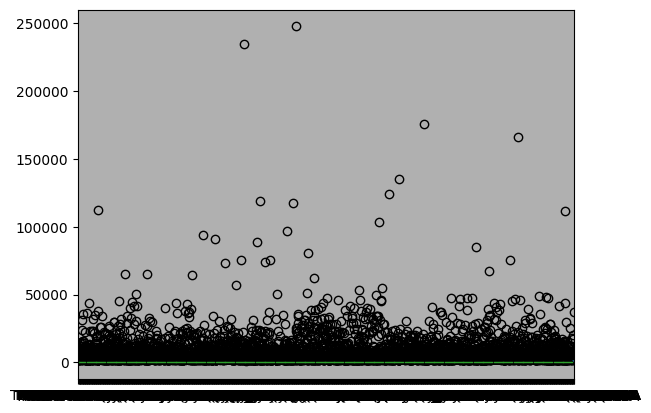

In [28]:
# The pre-processed data does not look normalised nor scaled
tcga_df[:100].boxplot() 

In [29]:
# Filter out genes that are < 10 TPMs in all samples
tcga_df = tcga_df[tcga_df.sum(axis = 1) > 10].copy() #Remove lowly expressed genes

# Log-transform TPMs + epsilon (the smallest positive float value greater than 0)
tcga_df_norm = np.log2(tcga_df + np.finfo(float).eps)
tcga_df_norm.head()

,TCGA-3C-AAAU-01A,TCGA-3C-AALI-01A,TCGA-3C-AALJ-01A,TCGA-3C-AALK-01A,TCGA-4H-AAAK-01A,TCGA-5L-AAT0-01A,TCGA-5L-AAT1-01A,TCGA-5T-A9QA-01A,TCGA-A1-A0SB-01A,TCGA-A1-A0SD-01A,...,TCGA-UL-AAZ6-01A,TCGA-UU-A93S-01A,TCGA-V7-A7HQ-01A,TCGA-W8-A86G-01A,TCGA-WT-AB41-01A,TCGA-WT-AB44-01A,TCGA-XX-A899-01A,TCGA-XX-A89A-01A,TCGA-Z7-A8R5-01A,TCGA-Z7-A8R6-01A
gene_id,,,,,,,,,,,,,,,,,,,,,
A1BG,7.622711,7.891079,8.725322,7.577565,8.070824,7.670812,7.723122,8.295466,5.620563,7.152772,...,5.464476,8.330805,10.011311,9.058095,6.904617,8.880456,7.802322,7.995117,8.779860,7.956097
A1CF,-52.000000,-52.000000,-0.141462,-52.000000,-1.232769,-52.000000,-52.000000,-0.935117,-52.000000,-52.000000,...,-1.324816,-52.000000,-52.000000,-1.075216,-52.000000,-52.000000,-52.000000,1.239887,-52.000000,-52.000000
A2BP1,-52.000000,-52.000000,-52.000000,-52.000000,1.937269,-0.769551,-52.000000,-0.935117,2.171527,-1.595969,...,-52.000000,-52.000000,-0.699466,2.384243,2.242420,-52.000000,-1.344831,0.502942,-0.743472,-52.000000
A2LD1,6.685982,6.146993,7.333245,5.965950,7.270249,6.801353,6.672029,7.868014,5.243981,6.063136,...,7.561181,7.814384,6.967872,5.900026,8.285670,5.947919,7.035932,6.320649,6.345201,4.654584
A2M,12.501432,12.886455,13.109896,13.419987,13.226629,13.590037,13.911261,11.635936,14.948865,14.538280,...,12.181168,11.785608,12.975045,14.161526,13.225956,12.401229,14.312656,14.061270,15.168927,12.841401


<b>Outlier detection and removal </b><br>
The hotellings T2 test is used to detect outliers across the multidimensional space of PCA, which outputs a P-value matrix (samples x PCs) that are are subsequently combined using fishers method. This allows to determine outliers with its ranking (strongest to weak). 

In addition, outlier can be detected using SPE/DmodX (distance to model) based on the mean and covariance of the first 2 dimensions of X. 

Note that the SPE or Hotelling’s T2 are complementary to each other, so here the overlap of outliers detected by both methods are removed.

Note 2: it is utterly important to carefully standardize your data as PCA works under the assumption that the data is normal distributed, and is very sensitive to the variance of the variables. Or in other words, large differences between the ranges of variables will dominate over those with small ranges. For this, set the argument "normalize=True" in the pca() function below.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [75.0%] explained variance using the [19910] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [268] that covers the [75.00%] explained variance.
[pca] >The PCA reduction is performed on the [19910] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[268]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 268 Principal Components explain [75.11%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

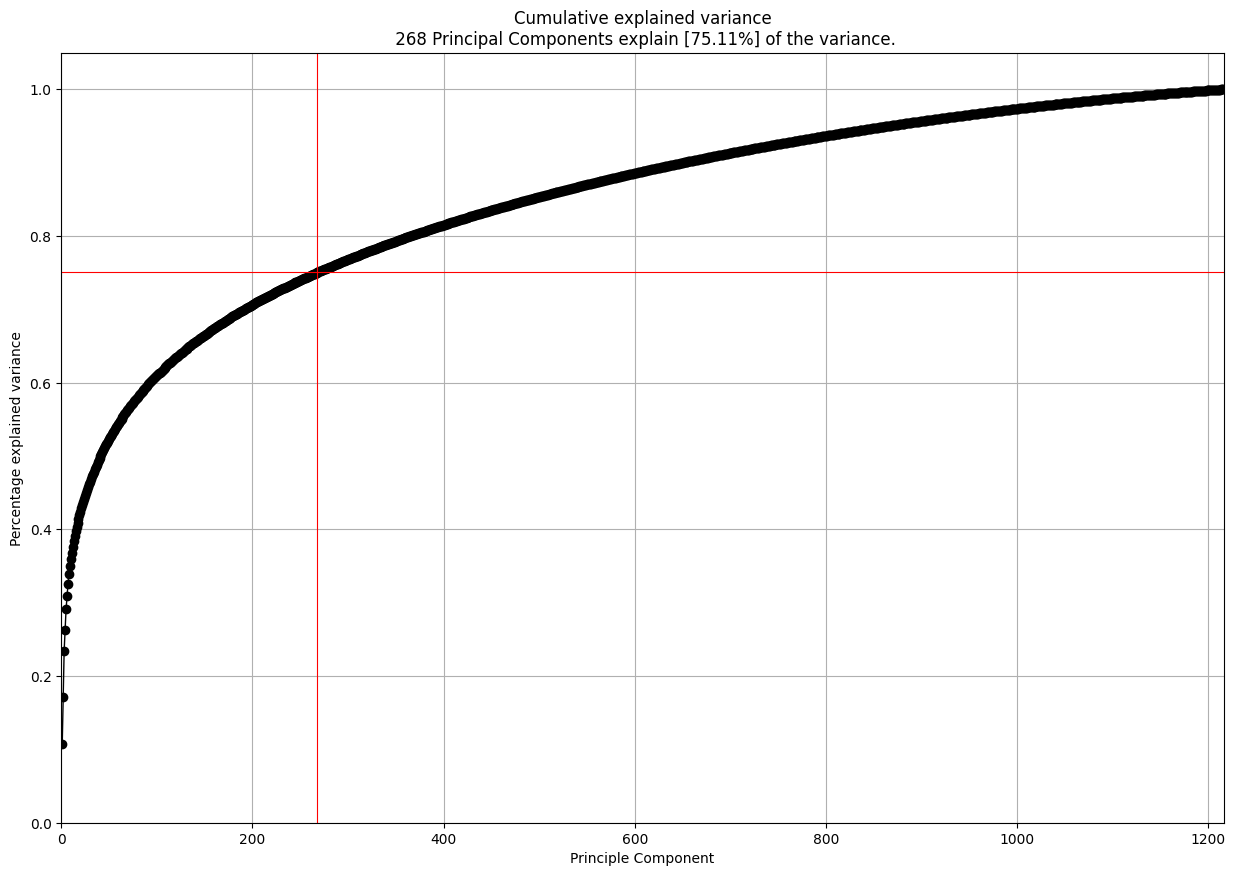

In [30]:
# Initialize pca
model = pca(normalize=True, n_components=0.75, 
            detect_outliers=['ht2', 'spe'], n_std= 3 )

# Fit transform with dataframe
results = model.fit_transform(tcga_df_norm.T)
model.plot()

In [31]:
#Top variable features (genes)-> ranked by |loading| 
model.results['topfeat']

,PC,feature,loading,type
0,PC1,TTBK2,-0.019205,best
1,PC2,GYPC,0.024056,best
2,PC3,SUV39H2,0.023720,best
3,PC4,CARD11,-0.028151,best
4,PC5,RBM33,-0.026666,best
...,...,...,...,...
19923,PC162,ZYG11A,-0.030856,weak
19924,PC1,ZYG11B,-0.016875,weak
19925,PC2,ZYX,0.018539,weak
19926,PC28,ZZEF1,0.020702,weak


In [32]:
#Print outliers (denoted by y_bool = True, y_bool_spe = True)
print(results['outliers'])

                        y_proba          p_raw      y_score  y_bool  \
TCGA-3C-AAAU-01A   1.000000e+00   9.544092e-01   481.952374   False   
TCGA-3C-AALI-01A   1.000000e+00   4.713418e-01   537.689242   False   
TCGA-3C-AALJ-01A   1.000000e+00   6.142362e-01   525.889144   False   
TCGA-3C-AALK-01A   1.000000e+00   1.000000e+00   237.799261   False   
TCGA-4H-AAAK-01A   1.000000e+00   1.000000e+00   235.335123   False   
...                         ...            ...          ...     ...   
TCGA-WT-AB44-01A  1.783067e-183  1.643650e-184  2106.326428    True   
TCGA-XX-A899-01A   1.000000e+00   1.000000e+00   235.516826   False   
TCGA-XX-A89A-01A   1.000000e+00   1.000000e+00   271.828747   False   
TCGA-Z7-A8R5-01A  1.002190e-116  2.326071e-117  1674.869681    True   
TCGA-Z7-A8R6-01A   1.000000e+00   1.000000e+00   359.823945   False   

                  y_bool_spe  y_score_spe  
TCGA-3C-AAAU-01A       False    34.801607  
TCGA-3C-AALI-01A       False    54.186170  
TCGA-3C-AALJ-01

[datazets] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (10.6% expl.var)', ylabel='PC2 (6.51% expl.var)'>)

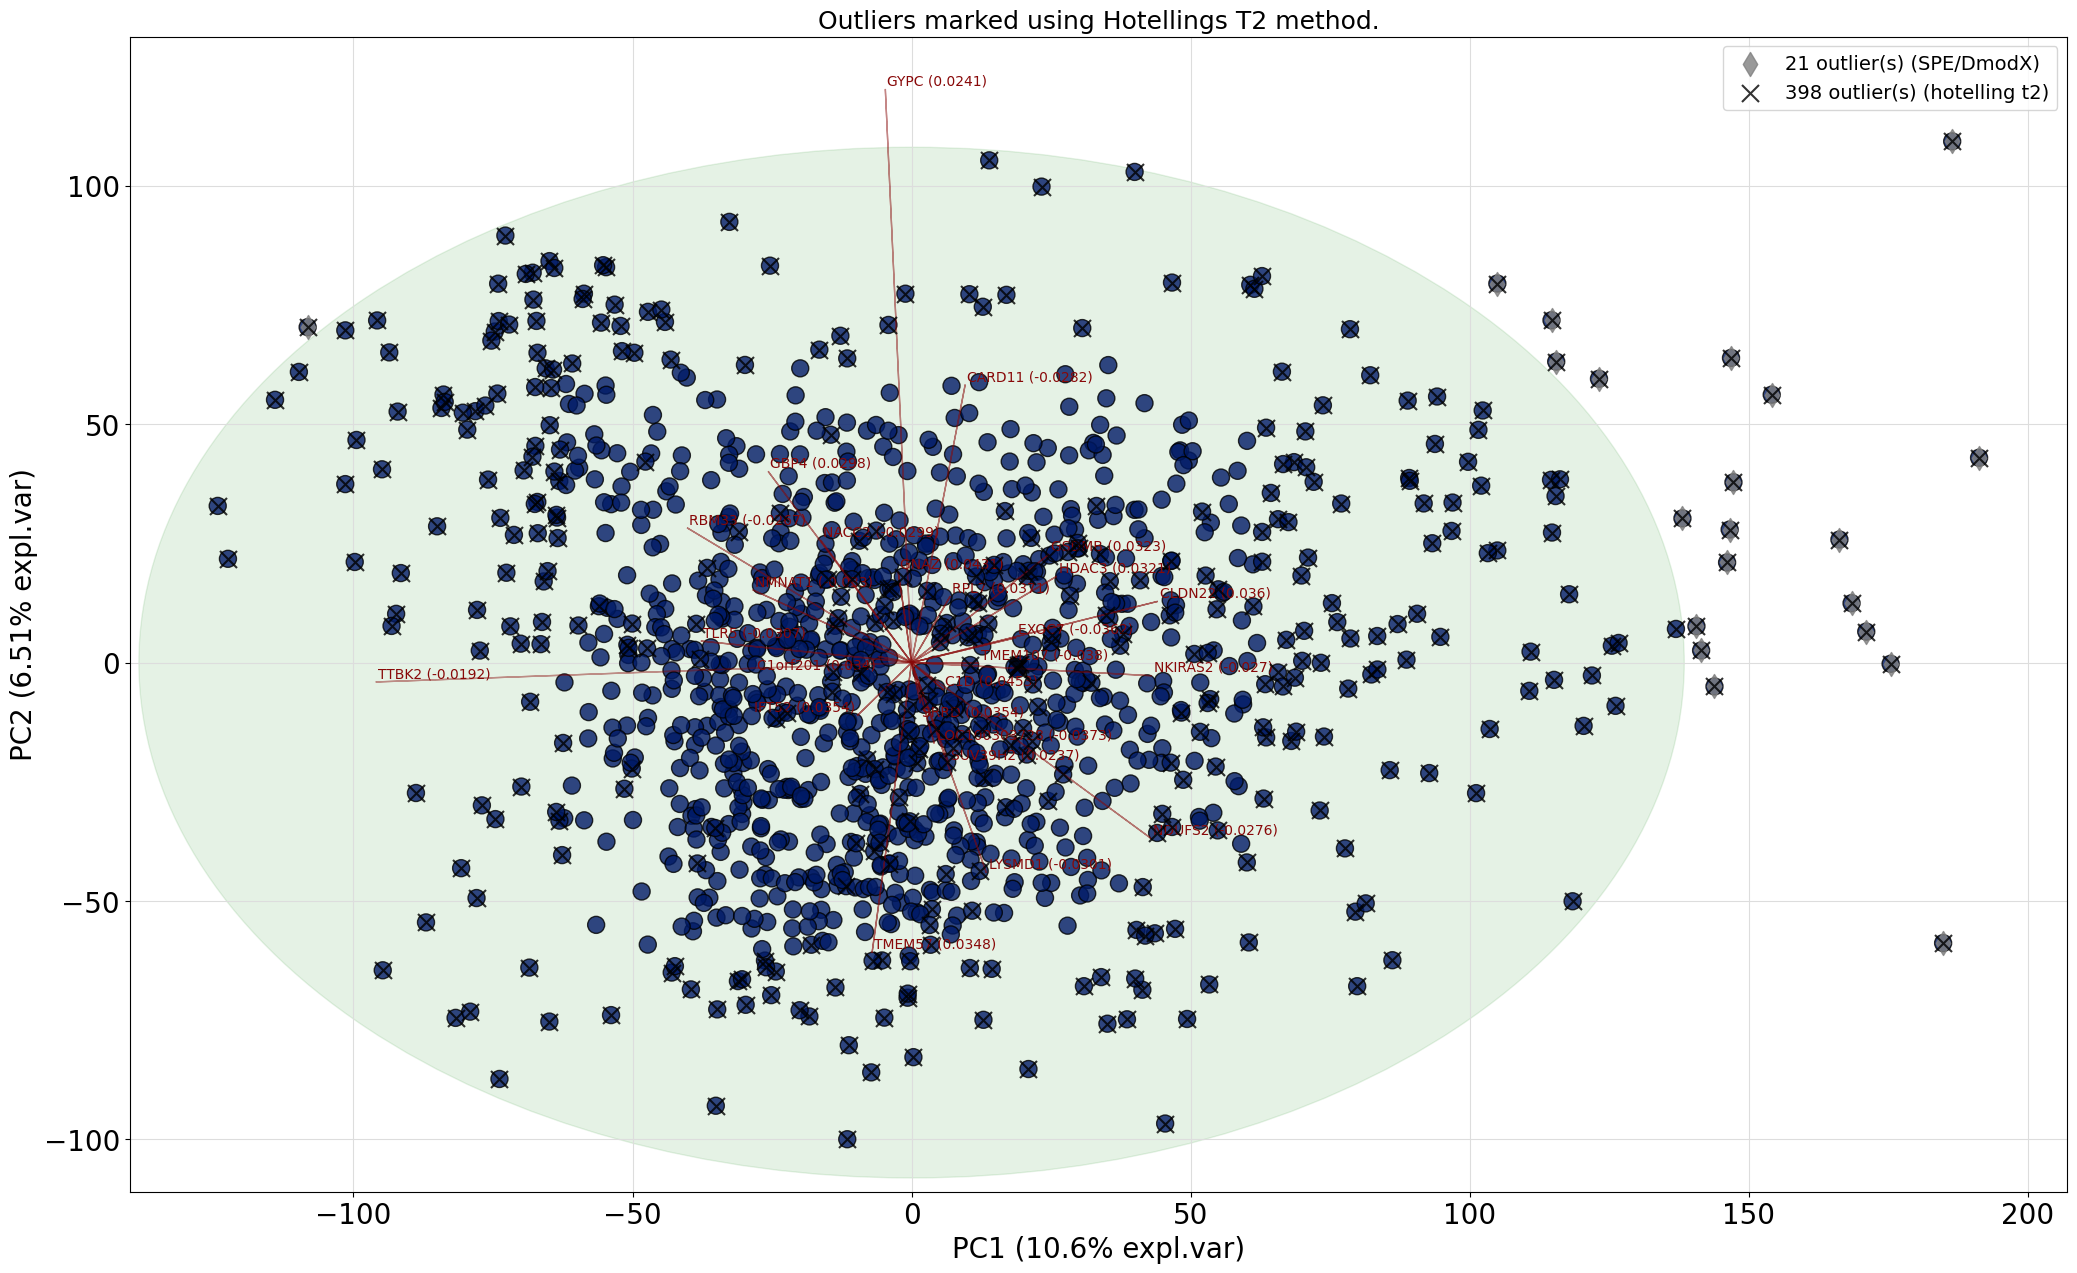

In [33]:
# Plot Hotellings T2 ellipse with data points shaped as rombus if SPE-detected outlier, and cross if HT2-dected outlier
model.biplot(HT2=True, 
             SPE = True,
             fontsize = 10 ,title='Outliers marked using Hotellings T2 method.')

In [34]:
# Get the outliers using SPE/DmodX method
tcga_df_norm.T.loc[results['outliers']['y_bool_spe'], :]

# Grab the overlapping outliers between HT2 and SPE
I_overlap = np.logical_and(results['outliers']['y_bool'], 
                           results['outliers']['y_bool_spe'])

# Remove outlier outliers
tcga_df_rm_outliers = tcga_df_norm.T.loc[~I_overlap, :]

tcga_df_rm_outliers # 1194 rows × 19935 columns

gene_id,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-3C-AAAU-01A,7.622711,-52.000000,-52.000000,6.685982,12.501432,0.463204,6.092596,3.107102,-1.536587,9.342824,...,8.699829,9.864120,7.017833,9.976965,10.695663,8.013987,10.238847,11.776125,10.887929,10.205133
TCGA-3C-AALI-01A,7.891079,-52.000000,-52.000000,6.146993,12.886455,2.121082,7.300984,-0.878852,-52.000000,9.794388,...,10.181562,9.914681,5.902438,8.809328,10.391372,7.632828,9.237423,12.426427,10.364846,8.667974
TCGA-3C-AALJ-01A,8.725322,-0.141462,-52.000000,7.333245,13.109896,-52.000000,9.164628,-52.000000,-52.000000,9.498811,...,8.254660,11.305651,5.143969,9.060691,9.586487,8.374266,9.055784,12.414355,9.880935,8.992992
TCGA-3C-AALK-01A,7.577565,-52.000000,-52.000000,5.965950,13.419987,0.726744,8.984171,-52.000000,-52.000000,9.601763,...,8.623903,9.384993,5.782065,8.773907,9.754689,7.454702,9.246420,12.474555,9.609426,9.453001
TCGA-4H-AAAK-01A,8.070824,-1.232769,1.937269,7.270249,13.226629,1.767358,8.418392,-1.232769,-1.232769,9.677982,...,8.664309,9.397606,5.612830,8.728788,10.035885,3.811738,9.599439,11.980747,9.700292,9.784147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01A,8.880456,-52.000000,-52.000000,5.947919,12.401229,2.703987,8.478770,-0.296013,-52.000000,10.306677,...,7.228953,7.498402,4.610871,7.927985,9.594248,6.622847,8.300174,13.416943,9.645032,8.791446
TCGA-XX-A899-01A,7.802322,-52.000000,-1.344831,7.035932,14.312656,-1.344831,8.981602,-0.344831,-52.000000,9.465744,...,8.833039,8.836325,6.147024,9.330247,10.306677,4.410056,9.426661,12.321395,10.917268,9.388187
TCGA-XX-A89A-01A,7.995117,1.239887,0.502942,6.320649,14.061270,5.800623,9.265601,1.502942,-0.082072,9.816581,...,9.050387,9.439580,5.604481,8.415830,10.425772,7.360926,9.544601,12.419318,10.489256,9.897404
TCGA-Z7-A8R5-01A,8.779860,-52.000000,-0.743472,6.345201,15.168927,1.256588,8.834000,-52.000000,-52.000000,10.027229,...,7.435537,8.014796,5.011460,7.957009,9.637032,5.699516,8.982788,12.704688,9.559211,9.552341


In [35]:
# Standardise the data with z-transformation
tcga_df_transformed = pd.DataFrame(StandardScaler().fit_transform(tcga_df_rm_outliers), 
                                   index= tcga_df_rm_outliers.index, #index are samples
                                   columns=tcga_df_rm_outliers.columns) #columns are genes 

tcga_df_transformed.head()

gene_id,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-3C-AAAU-01A,0.551302,-0.485691,-0.985603,0.436902,-1.050763,0.111147,-1.761850,0.825858,3.053543,-0.150414,...,0.021023,0.542331,1.642402,1.417056,1.682678,0.644422,0.847815,-0.020980,1.120096,0.639724
TCGA-3C-AALI-01A,0.778716,-0.485691,-0.985603,-0.267699,-0.682738,0.218304,-0.672344,0.661955,-0.323228,0.933385,...,2.215866,0.584168,-0.070205,-0.336980,0.815319,0.531309,-1.042075,0.917797,0.229364,-2.011773
TCGA-3C-AALJ-01A,1.485651,2.099254,-0.985603,1.283045,-0.469162,-3.279797,1.007953,-1.440154,-0.323228,0.223972,...,-0.638391,1.735103,-1.234778,0.040619,-1.478948,0.751338,-1.384864,0.900369,-0.594665,-1.451138
TCGA-3C-AALK-01A,0.513045,-0.485691,-0.985603,-0.504370,-0.172761,0.128181,0.845249,-1.440154,-0.323228,0.471066,...,-0.091443,0.145886,-0.255028,-0.390189,-0.999501,0.478448,-1.025095,0.987274,-1.057004,-0.657654
TCGA-4H-AAAK-01A,0.931031,2.044857,1.080006,1.200692,-0.357582,0.195441,0.335133,0.647402,3.073873,0.653999,...,-0.031592,0.156322,-0.514876,-0.457968,-0.197972,-0.602638,-0.358877,0.274412,-0.902272,-0.086449


### (3) QC analysis
PCA plot coloured based on relevant metadata -> ensure no batch effects


In [36]:
pca_to_plot = tcga_df_transformed.join(sample_metadata[['sample_type']])
pca_to_plot.head(3)

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,sample_type
TCGA-3C-AAAU-01A,0.551302,-0.485691,-0.985603,0.436902,-1.050763,0.111147,-1.761850,0.825858,3.053543,-0.150414,...,0.542331,1.642402,1.417056,1.682678,0.644422,0.847815,-0.020980,1.120096,0.639724,Primary Tumor
TCGA-3C-AALI-01A,0.778716,-0.485691,-0.985603,-0.267699,-0.682738,0.218304,-0.672344,0.661955,-0.323228,0.933385,...,0.584168,-0.070205,-0.336980,0.815319,0.531309,-1.042075,0.917797,0.229364,-2.011773,Primary Tumor
TCGA-3C-AALJ-01A,1.485651,2.099254,-0.985603,1.283045,-0.469162,-3.279797,1.007953,-1.440154,-0.323228,0.223972,...,1.735103,-1.234778,0.040619,-1.478948,0.751338,-1.384864,0.900369,-0.594665,-1.451138,Primary Tumor


[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [19910] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [854] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [19910] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[854]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[colourmap] >Add transparency to RGB colors (last column)


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '854 Principal Components explain [95.03%] of the variance'}, xlabel='PC1 (9.61% expl.var)', ylabel='PC2 (6.59% expl.var)'>)

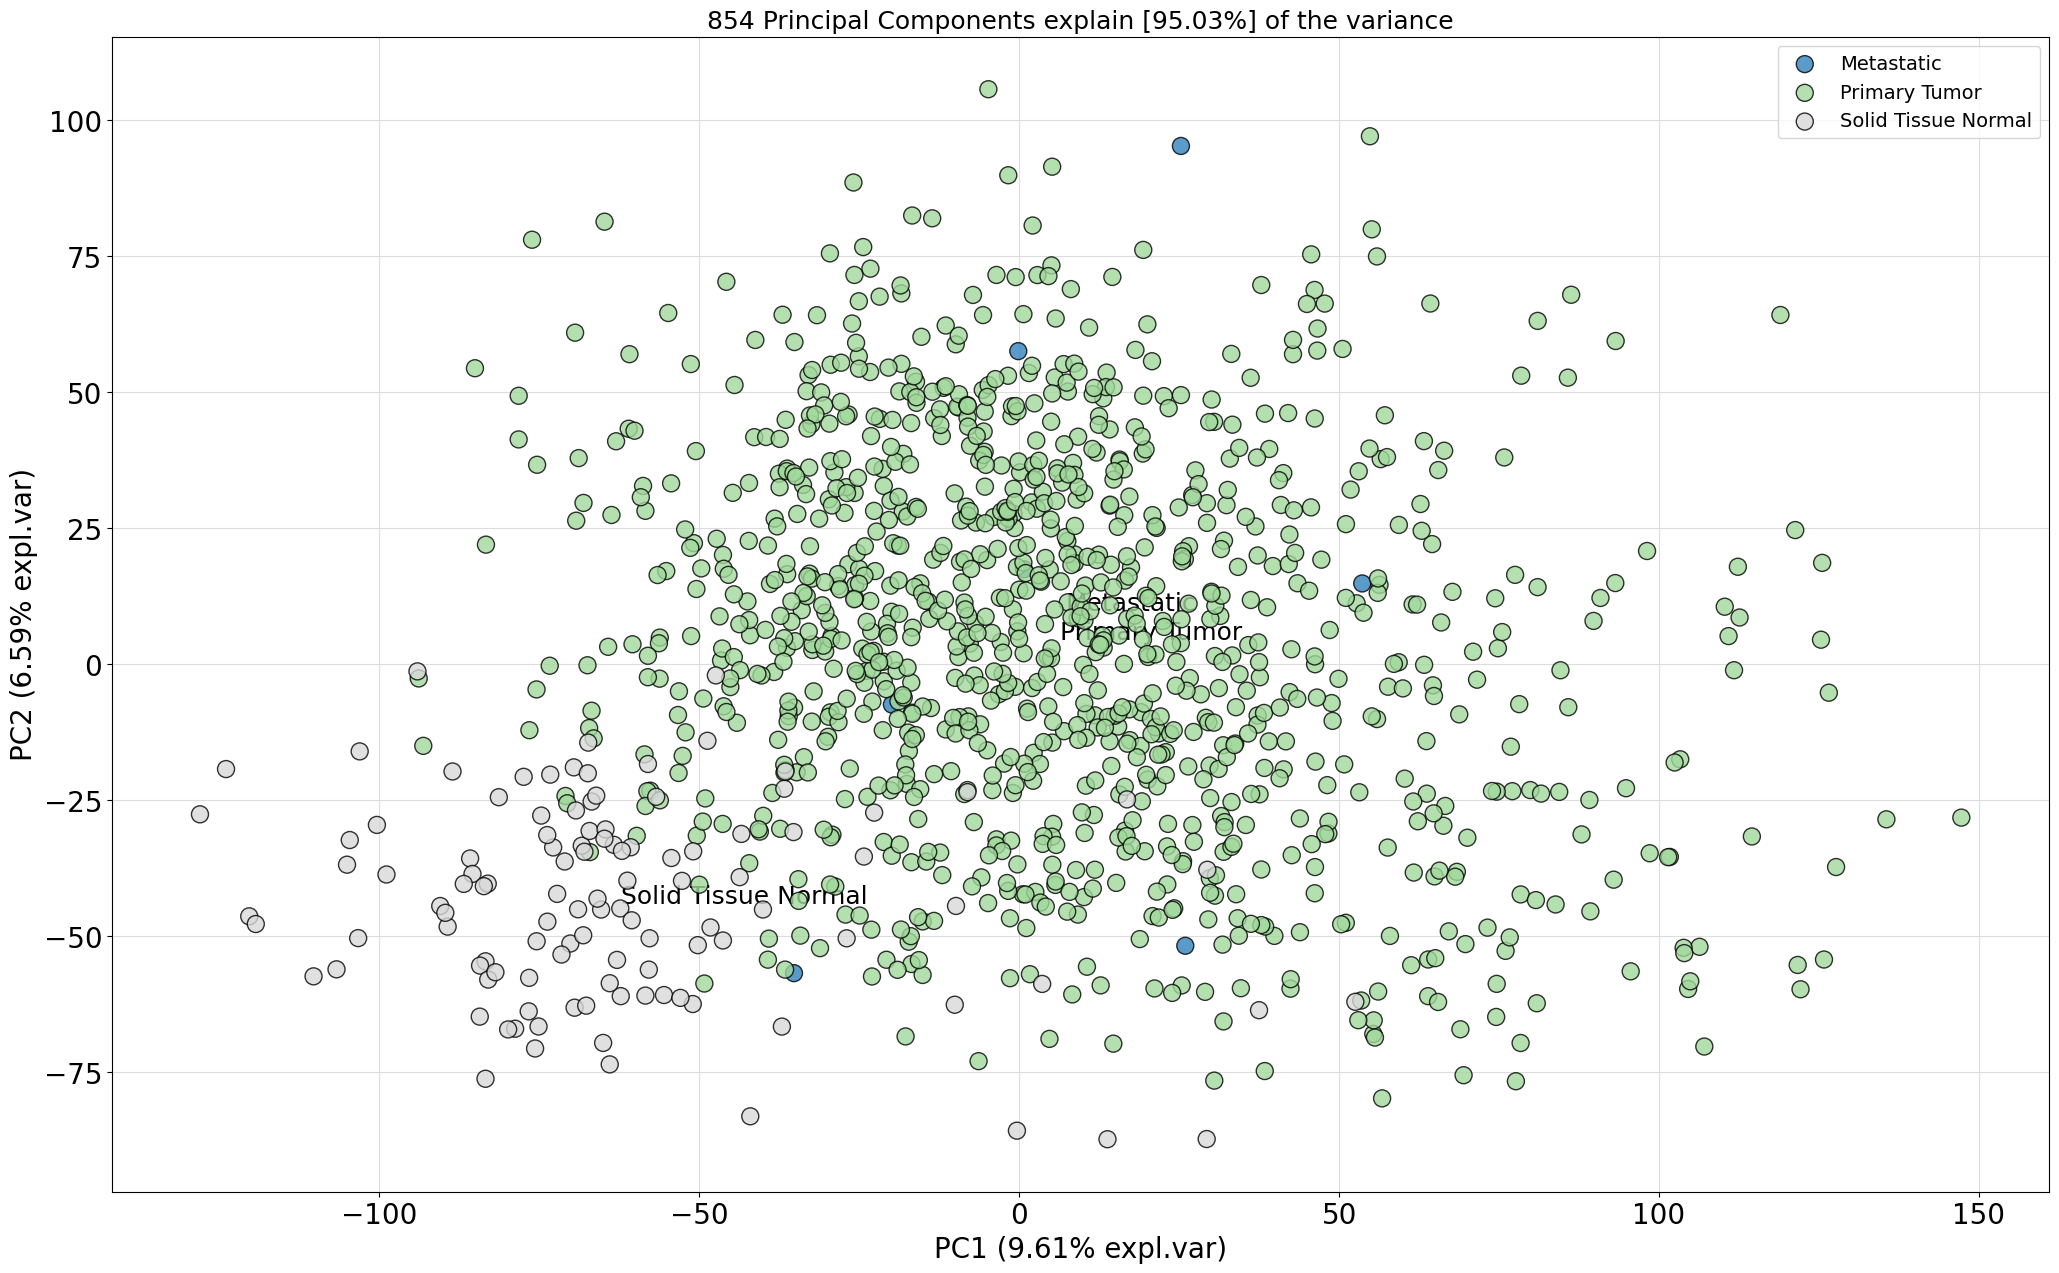

In [37]:
#from pca import pca
model = pca(normalize=False)

# Fit transform and include the column labels and row labels
results = model.fit_transform(pca_to_plot.loc[:, pca_to_plot.columns != 'sample_type'], 
                              col_labels=pca_to_plot.loc[:, pca_to_plot.columns != 'sample_type'].columns, 
                              row_labels=pca_to_plot.sample_type.to_list())

model.scatter() #No batch effects observed

### (4) Association analysis
The aim of this analysis is to evaluate and visualise patterns. 
* (4A) For instance, compute miR-361-3p signature enrichment (NES) in TCGA-BRCA and assess the difference in NES between normal, primary and metastatic tumour samples.  
* (4B) Compute the correlation between signature enrichment scoore in samples with the gene expression of a miR-361-3p target gene (FANCA) 

#### (4A) Compute miR-361-3pm signature enrichment in TCGA-BRCA patients and assess 
For gene signatures - here the miR-361-3p inhibition signature is used. This signature was generated from differential gene expression performed on RNA-seq data generated from MCF7 (breast cancer) tumour xenografts treated with ASO-361-3p vs AS-NC (negative contrl oligo) [https://pubmed.ncbi.nlm.nih.gov/36622663/]

In [67]:
#Upload a signature of interest (e.g. miR-361-3p signature genes)
miR361_signature = pd.read_csv('tt_table_GR_EdgeR.txt', sep=',', index_col= 'Unnamed: 0')

miR361_signature = miR361_signature[(miR361_signature.FDR < 0.05) & 
                                    (miR361_signature.logFC > 1)].symbol.dropna().to_list()

In [68]:
#Perform ssGSEA to identify which samples are enriched for the miR-361-3p signature  
ss = gseapy.ssgsea(
        data = tcga_df_transformed.T,
        gene_sets =  {'pathway': miR361_signature},
        sample_norm_method = 'rank',
        no_plot = True,
        threads = 4)
es = ss.res2d.copy()

2023-07-14 09:43:38,598 [WARNING] Dropping duplicated gene names, values averaged by gene names!


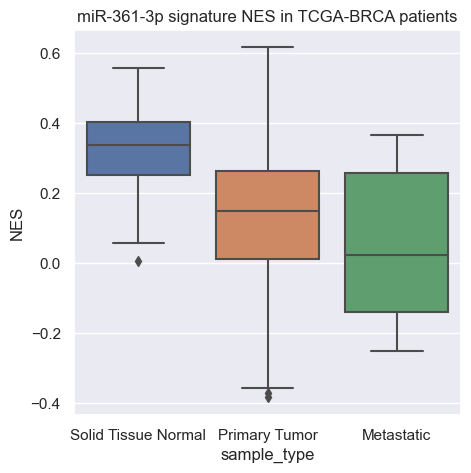

In [90]:
#Plot normalised enrichment score between samples
nes_data = pd.merge(es, sample_metadata[['sample_type']], left_on='Name', right_on='sample_submitter_id')

utils.generate_boxplot(nes_data)

#### (4B) Correlation between signature enrichment score and FANCA expression

In [98]:
correlation_df = pd.merge(nes_data, tcga_df_transformed[['FANCA']], left_on = 'Name', right_index = True )


In [109]:
correlation_df['FANCA'] = correlation_df['FANCA'].astype(float)
correlation_df['NES'] = correlation_df['NES'].astype(float)

In [113]:
from scipy import stats


/Users/joannazamarbide/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


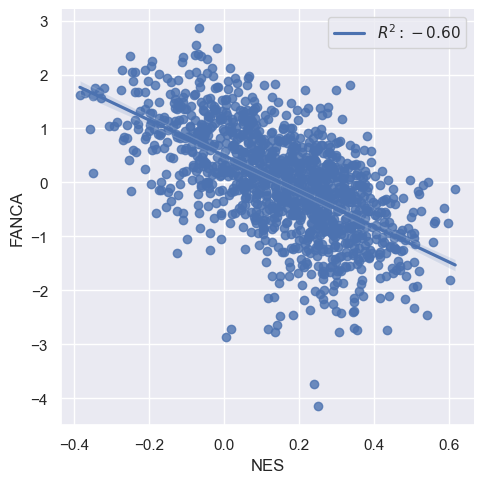

In [126]:
p = sns.lmplot(x='NES', y='FANCA',
        data=correlation_df,
        line_kws={'label':"Linear Reg"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()

slope, intercept, r_value, p_value, std_err = stats.linregress(correlation_df['NES'],
                                                               correlation_df['FANCA'])
label_line_1 = r'$y={0:.1f}x+{1:.1f}'.format(slope,intercept)
L_labels[0].set_text(label_line_2)


### Multivariate analysis

Unsupervised ML is applied to TCGA-BRCA data to extract pathway-level molecular signatures. Independent component analysis (ICA) is an unsupervised learning method widely used in signal processing and has been applied to cancer genomics with notable success (). This approach decomposes the molecular profiles into linear combinations of non-Gaussian independent sources or components, each of which is comprised of weighted contributions from individual genes. Therefore, ICA reduces the dimensionality of original data by representing the molecular profile of each sample as weighted sum of several “meta-genes” and the weight of specific meta-gene (mixing scores) in one sample reflects the “activity” of that component in the sample. 

Different from the more conventional dimension reduction method PCA, ICA is able to discover more informative representations of high-dimensional biological signals, which are usually super-Gaussian and contain more close-to-zero values than a normally-distributed sample. Instead, PCA seeks to find uncorrelated factors that explain the variance among the data, and works the best when the underlying components are normally distributed.

In [ ]:
n_components = 300

loadings, factors = utils.run_ica(n_components, tcga_df_transformed)


In [ ]:
output = utils.compute_stats(factors.iloc[:, :5], sample_metadata) #compute stats for 5 first latents
output #TODO: ADD MULTIPLE TESTING CORRECTION!

L0
L1
L2
L3
L4


,latent,variable,cor,pvalue
0,L0,Solid Tissue Normal v Primary Tumor,41658.0,7.852238e-08
0,L0,Solid Tissue Normal v Metastatic,163.0,7.710174e-03
0,L0,Primary Tumor v Metastatic,2654.0,1.827760e-01
0,L1,Solid Tissue Normal v Primary Tumor,54540.0,1.011596e-01
0,L1,Solid Tissue Normal v Metastatic,226.0,6.061835e-02
0,L1,Primary Tumor v Metastatic,3268.0,5.565894e-01
0,L2,Solid Tissue Normal v Primary Tumor,40239.0,7.403722e-09
0,L2,Solid Tissue Normal v Metastatic,355.0,6.864066e-01
0,L2,Primary Tumor v Metastatic,4448.0,4.138748e-01
0,L3,Solid Tissue Normal v Primary Tumor,12325.0,1.007960e-43


In [ ]:
output.sort_values(by = 'pvalue', ascending = True)

,latent,variable,cor,pvalue
0,L3,Solid Tissue Normal v Primary Tumor,12325.0,1.007960e-43
0,L4,Solid Tissue Normal v Primary Tumor,24830.0,1.250476e-24
0,L2,Solid Tissue Normal v Primary Tumor,40239.0,7.403722e-09
0,L0,Solid Tissue Normal v Primary Tumor,41658.0,7.852238e-08
0,L3,Solid Tissue Normal v Metastatic,86.0,1.420155e-04
0,L4,Solid Tissue Normal v Metastatic,100.0,3.558550e-04
0,L0,Solid Tissue Normal v Metastatic,163.0,7.710174e-03
0,L1,Solid Tissue Normal v Metastatic,226.0,6.061835e-02
0,L1,Solid Tissue Normal v Primary Tumor,54540.0,1.011596e-01
0,L3,Primary Tumor v Metastatic,2478.0,1.208903e-01


/Users/joannazamarbide/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


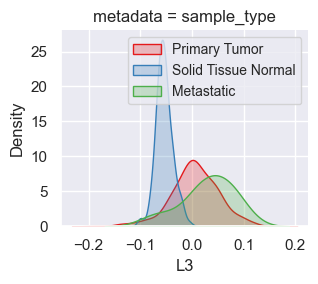

In [ ]:
latent = 'L3'

full_df = factors.join(sample_metadata).reset_index().rename(columns  ={'index': 'sample_ids'})
df_latent = full_df[['sample_ids', latent, 'sample_type']]
df_melt = df_latent.melt(id_vars = [latent,'sample_ids'],
                         var_name = 'metadata', 
                         value_name = 'metadata_value')


sns.set(font_scale=1)  # crazy big

g = sns.FacetGrid(df_melt, col='metadata', 
                  hue="metadata_value", 
                  palette="Set1", col_wrap = 2, sharey=False, sharex = False)
g = (g.map(sns.kdeplot, latent, fill = True))

for ax in g.axes.ravel():
    ax.legend(fontsize = 'small')